<h1 style="text-align:center;">Building makemore (IV) : Manual Backpropagation</h1>




Additional links :
    
- [BatchNorm paper](https://arxiv.org/pdf/1502.03167.pdf)
- [Bessel’s Correction](https://math.oxford.emory.edu/site/math117/besselCorrection/)
- [Bengio et al. 2003 MLP LM](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)


In [1]:
# there no change change in the first several cells from last notebook (part IV)

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Loading the data

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(f"The total number of words : {len(words)}")
print(f"The longest word has {max(len(w) for w in words)} charachters")
print(f"The 8 first words are : {words[:8]}")

The total number of words : 32033
The longest word has 15 charachters
The 8 first words are : ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [4]:
chars = sorted(list(set(''.join(words))))

# Encoder : convert string to integer
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
print(f"The encoder (string to integer) that we're going to work with is :\n{stoi}\n")

# Decoder : convert integer to string
itos = {i:s for s,i in stoi.items()}
print(f"The decoder (integer to string) that we're going to work with is :\n{itos}")

# Vocabulary size
vocab_size = len(itos)

print(f"The vocabulary of size {len(itos)} we're working with is :\n{itos.values()}\n")

The encoder (string to integer) that we're going to work with is :
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}

The decoder (integer to string) that we're going to work with is :
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
The vocabulary of size 27 we're working with is :
dict_values(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '.'])



# Building the dataset

In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one? (T : time dimension)

def build_dataset(words):
    """Takes a list of some words and builds the arrays X and Y
    for those words only"""
    
    X, Y = [], []
  
    for w in words:
        context = [0] * block_size   # initial context is 3 dots '...'
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    
    # convert the lists into toch tensors
    X = torch.tensor(X)    # contexts
    Y = torch.tensor(Y)    # indexes of the ground truths
    print(X.shape, Y.shape)
    return X, Y


import random
random.seed(42)
random.shuffle(words)      # Shuffling the words
n1 = int(0.8*len(words))   # length of the training data (80%)
n2 = int(0.9*len(words))   # length of validation data (10%), and the remaigning 10% is for testing

# Building training, validation and testing datasets
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


Boilerplate done, now we get to the action :

# Manual Backpropagation

In PyTorch, when we perform operations that involve gradients, such as backpropagation, the gradients are typically stored in the `.grad` attribute of the tensors involved. This attribute holds the computed gradients, which can then be used for optimization algorithms like gradient descent.

To truly understand how backpropagation works, we will write lines of code to calculate the gradient of the loss function with respect to each parameter. We will then use the helper function `cmp()` below to compare the results with Torch's `.grad` attribute.

In [6]:
def cmp(s, dt, t):
    """compares the manually calculated gradients to PyTorch gradients.
        s : (string) name of the parameter
        dt : calculated gradient
        t : parameter"""
    
  # dt calculated by us, and t.grad calculated by pytorch
    ex = torch.all(dt == t.grad).item()         # verifying if they're equal, 'ex' is boolean
    app = torch.allclose(dt, t.grad)            # if note exactly equal, 'app' is boolean
    maxdiff = (dt - t.grad).abs().max().item()  # the error between the two, 'maxdiff' is float
    print(f"{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}")

In the provided code snippet, `g` is an instance of `torch.Generator` that is used to control the randomness of the generated values. By setting a seed for the generator, we ensure that the random numbers generated by PyTorch are reproducible.

Here's a breakdown of the role of `g`:

* **torch.Generator :** This class in PyTorch provides functionality for generating random numbers. We can create an instance of `torch.Generator` using various methods.

* **manual_seed :** The `.manual_seed()` method sets the seed for the random number generator. By setting the seed to a specific value (in this case, 25101989), we ensure that the sequence of random numbers generated by the generator will be the same every time our code is run with the same seed.

* **generator=g :** The generator argument specifies the generator to be used for generating random numbers. By passing the `g` generator instance to the generator argument when calling `torch.randn()`, we ensure that the random numbers generated by `torch.randn()` will be reproducible based on the seed set for `g`.

In summary, `g` is used to control the randomness of the generated values by setting a seed for the random number generator. This ensures that the random numbers generated by `torch.randn()` will be consistent and reproducible across different runs of the code, which can be crucial for debugging, testing, and ensuring consistent results in machine learning experiments.

## Building the MLP model

In [7]:
n_embd = 10           # the dimensionality of the character embedding vectors (C : channels dimension)
n_hidden = 64         # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(25101989) # for reproducibility
C  = torch.randn((vocab_size, n_embd), generator=g)  # embedding table : shape(vocab_size, n_embd)

# hidden layers
## Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)  # shape(n_embd * block_size, n_hidden)
b1 = torch.randn(n_hidden, generator=g) * 0.1 # using b1 just for fun, it's useless because of BN. shape (n_hidden)
# Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1  # shape (n_hidden, vocab_size)
b2 = torch.randn(vocab_size, generator=g) * 0.1  # shape (vocab_size)
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0   # shape(1, n_hidden)
bnbias = torch.randn((1, n_hidden))*0.1         # shape(1, n_hidden)

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

# (learnable) model parameters :
parameters = [C, W1, b1, W2, b2, bngain, bnbias]

# number of parameters in total
print(sum(p.nelement() for p in parameters)) 
for p in parameters:
    p.requires_grad = True

4137


In [8]:
batch_size = 32  # B, Batch dimension
n = batch_size   # a shorter variable also, for convenience

# construct a minibatch : sampling 32 random Xtr indeces, and use them to exract 32 random rows from Xtr (batch)
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [9]:
print(Xb.shape, Yb.shape, C.shape)

torch.Size([32, 3]) torch.Size([32]) torch.Size([27, 10])


In [10]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time
# I chunkated into multiple steps to make the operation explicit, facilitating the calcul of the gradients

emb = C[Xb] # embed the characters into vectors ; shape(batch_size, block_size, n_embd)
embcat = emb.view(emb.shape[0], -1) # Flatten for each example from the batch, i.e. concatenate the vectors ; shape(batch_size, block_size * n_embd)

# Linear layer 1
### hprebn shape : (batch_size, block_size * n_embd) @ (block_size * n_embd, n_hidden) + (n_hidden) ----broadcasting---->
## (batch_size, n_hidden) + (n_hidden) ---broadcasting--> (batch_size, n_hidden) + (batch_size, n_hidden)----> (batch_size, n_hidden)
hprebn = embcat @ W1 + b1 # hidden layer pre-batch normalization ; shape(batch_size,n_hidden)
# BatchNorm (bn) layer
## Calculating the mean & variance of each feature (i.e. output of each neurone)
### bnmeani shape : (batch_size,n_hidden)---sum(0,keepdim)--->(1,n_hidden)
bnmeani = 1/n*hprebn.sum(0, keepdim=True)  # shape(1,n_hidden)
### bndiff shape :(batch_size,n_hidden)-(1,n_hidden)---broadcasting-->(batch_size,n_hidden)-(batch_size,n_hidden)---->(batch_size,n_hidden)
bndiff = hprebn - bnmeani             # (batch_size,n_hidden)           
bndiff2 = bndiff**2                         #shape(batch_size,n_hidden)
### bnvar shape : (batch_size,n_hidden)---sum(0,keepdim)---->(1,n_hidden)
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # variance; note: Bessel's correction (dividing by n-1, not n) 
bnvar_inv = (bnvar + 1e-5)**-0.5    # shape(1,n_hidden); epsilon = 1e-5
### bnraw shape : (batch_size,n_hidden) * (1,n_hidden)----broadcasting--->(batch_size,n_hidden)*(batch_size,n_hidden)------>(batch_size,n_hidden)
bnraw = bndiff * bnvar_inv  # (batch_size,n_hidden)
### hpreact shape : (1, n_hidden) * (batch_size,n_hidden) + (1, n_hidden) ---broadcasting---> 
###(batch_size,n_hidden)*(batch_size,n_hidden) + (1, n_hidden)--- * is element-wise mutlipl--->
##(batch_size,n_hidden)+(1, n_hidden)---broadcasting---->(batch_size,n_hidden)+(batch_size,n_hidden)
##---->(batch_size,n_hidden) 
hpreact = bngain * bnraw + bnbias   # (batch_size,n_hidden) 
# Non-linearity
h = torch.tanh(hpreact) # hidden layer ; shape(batch_size,n_hidden)

# Linear layer 2
### logits shape : (batch_size,n_hidden) @ (n_hidden, vocab_size) + (vocab_size) ---brodacasting---> (batch_size,vocab_size)
logits = h @ W2 + b2 # output layer ; shape(batch_size,vocab_size)
# cross entropy loss (same as F.cross_entropy(logits, Yb))
### logit_maxes shape : (batch_size,vocab_size)---max(1,keepdim)--->(batch_size,1)
logit_maxes = logits.max(1, keepdim=True).values   # shape(batch_size, 1)
### norm_logits shape : (batch_size,vocab_size) - (batch_size, 1) ---broadcasting---> (batch_size,vocab_size)
norm_logits = logits - logit_maxes # subtract max for numerical stability # shape(batch_size, vocab_size)
counts = norm_logits.exp()   # shape(batch_size, vocab_size)
### counts_sum shape : (batch_size, vocab_size)---sum(1,keepdim)--->(batch_size, 1)
counts_sum = counts.sum(1, keepdims=True)  # shape(batch_size, 1)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...#shape(batch_size, 1)
### probs shape : (batch_size, vocab_size) * (batch_size, 1)---broadcasting---> (batch_size, vocab_size)
probs = counts * counts_sum_inv   # shape(batch_size,vocab_size)
logprobs = probs.log()            # shape(batch_size,vocab_size)
loss = -logprobs[range(n), Yb].mean()  # calculating the mean of -logprobas assigned by the model to the ground truths (n is the batch_size)

# PyTorch backward pass
for p in parameters:
    p.grad = None  # set the grad to zero in Pytorch
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # as far as I know there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani, embcat, emb]:
    t.retain_grad()
loss.backward()
loss

tensor(3.1642, grad_fn=<NegBackward0>)

In [11]:
for k,v in {"logprobs" : logprobs, "probs":probs, "counts":counts, "counts_sum":counts_sum, "counts_sum_inv":counts_sum_inv, 
          "norm_logits":norm_logits, "logit_maxes":logit_maxes, "logits":logits, "bnraw": bnraw, "bngain": bngain, "bnraw":bnraw,
            "bnbias": bnbias, "h":h, "W2":W2, "b2":b2, "hpreact":hpreact, "bnraw":bnraw,"bnvar_inv":bnvar_inv, "bnvar":bnvar,
            "bndiff2":bndiff2, "bndiff":bndiff, "hprebn":hprebn, "bnmeani":bnmeani, "embcat":embcat, "emb":emb}.items() :
    print(f"The shape of {k} is : {v.shape}\n")

The shape of logprobs is : torch.Size([32, 27])

The shape of probs is : torch.Size([32, 27])

The shape of counts is : torch.Size([32, 27])

The shape of counts_sum is : torch.Size([32, 1])

The shape of counts_sum_inv is : torch.Size([32, 1])

The shape of norm_logits is : torch.Size([32, 27])

The shape of logit_maxes is : torch.Size([32, 1])

The shape of logits is : torch.Size([32, 27])

The shape of bnraw is : torch.Size([32, 64])

The shape of bngain is : torch.Size([1, 64])

The shape of bnbias is : torch.Size([1, 64])

The shape of h is : torch.Size([32, 64])

The shape of W2 is : torch.Size([64, 27])

The shape of b2 is : torch.Size([27])

The shape of hpreact is : torch.Size([32, 64])

The shape of bnvar_inv is : torch.Size([1, 64])

The shape of bnvar is : torch.Size([1, 64])

The shape of bndiff2 is : torch.Size([32, 64])

The shape of bndiff is : torch.Size([32, 64])

The shape of hprebn is : torch.Size([32, 64])

The shape of bnmeani is : torch.Size([1, 64])

The shape o

## TASK 1 

We're going to backpropagate through the whol thing **manually**, backpropagating through exactly all the variables as they are defined in the forward pass above, one by one :

In [12]:
# ASTUCES :
## each time check the shapes of the parameters involved
## broadcasting turns into sum, and sum turns into broadcasting
## dX has the same shape as X 

dlogprobs = torch.zeros_like(logprobs)    # shape(batch_size,vocab_size)
dlogprobs[range(n), Yb] = -1.0/n          # populate dLoss/dlogprobs  
dprobs = (1.0 / probs) * dlogprobs        # dLoss/dprobs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)  # dloss/dcounts_sum_inv
dcounts = counts_sum_inv * dprobs
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum
dnorm_logits = counts * dcounts
dlogits = dnorm_logits.clone()   # 1* dnorm_logits
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
dh = dlogits @ W2.T   # dloss/dh   # using dimensions of h, W2, and dlogits, and that dZ is the same shape as Z
dW2 = h.T @ dlogits   # dloss/dW2   # logits = h @ W2 + b2
db2 = dlogits.sum(0)  # dloss/db2
dhpreact = (1.0 - h**2) * dh
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)   # * is a mulitplication element wise
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
dbndiff += (2*bndiff) * dbndiff2
dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff).sum(0, keepdim=True)
dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for l in range(Xb.shape[1]):
        ix = Xb[k,l]
        dC[ix] += demb[k,l]


# Verify the results with the grads given by pytorch : 
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

In [13]:
# TASK 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.1642212867736816 diff: 0.0


In [14]:
#dlogprobs = torch.zeros_like(logprobs)
#dlogprobs[range(n), Yb] = -1/n
#dprobs = dlogprobs*(1/probs)
#dcounts_sum_inv = (dprobs * counts).sum(1, keepdim=True) # from broadcasting to sum
#dcounts = dprobs * counts_sum_inv
#dcounts_sum = dcounts_sum_inv * (-1/counts_sum**2)
#dcounts += torch.ones_like(counts)  # from sum to broadcasting 
#dnorm_logits = dcounts * counts
#dlogits = (dnorm_logits *1).clone()
#dlogit_maxes = (dnorm_logits * -1).sum(1, keepdim =True)  # from broadcasting to sum
#dlogits += F.one_hot(logits.max(1).indices, num_classes = logits.shape[1])

In [17]:
# backward pass

dlogits = F.softmax(logits, 1) # computing the softmax along the columns 
dlogits[range(n), Yb] -=1     # subtructing 1 from the probabilities ossociated with the ground truths
dlogits /= n

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 5.587935447692871e-09


In [18]:
logits.shape, Yb.shape

(torch.Size([32, 27]), torch.Size([32]))

In [19]:
F.softmax(logits, 1)[0]

tensor([0.0383, 0.0822, 0.0419, 0.0236, 0.0293, 0.0323, 0.0391, 0.0579, 0.0490,
        0.0429, 0.0158, 0.0207, 0.0671, 0.0418, 0.0635, 0.0523, 0.0240, 0.0271,
        0.0206, 0.0445, 0.0248, 0.0324, 0.0240, 0.0162, 0.0406, 0.0219, 0.0260],
       grad_fn=<SelectBackward0>)

In [20]:
dlogits[0] * n

tensor([ 0.0383,  0.0822,  0.0419,  0.0236,  0.0293,  0.0323,  0.0391,  0.0579,
         0.0490,  0.0429,  0.0158,  0.0207,  0.0671,  0.0418,  0.0635,  0.0523,
         0.0240,  0.0271,  0.0206, -0.9555,  0.0248,  0.0324,  0.0240,  0.0162,
         0.0406,  0.0219,  0.0260], grad_fn=<MulBackward0>)

In [21]:
dlogits[0].sum()

tensor(-4.1910e-09, grad_fn=<SumBackward0>)

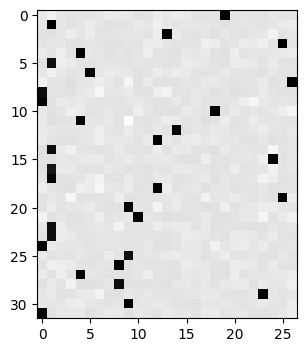

In [22]:
plt.figure(figsize=(4, 4))
plt.imshow(dlogits.detach(), cmap='gray')

In [23]:
# TASK 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative with regards to its input, simplify the expression, and just write it out

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [24]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [25]:
dhprebn.shape, bngain.shape, bnvar_inv.shape, dbnraw.shape, dbnraw.sum(0).shape

(torch.Size([32, 64]),
 torch.Size([1, 64]),
 torch.Size([1, 64]),
 torch.Size([32, 64]),
 torch.Size([64]))

# Summary
## Train the model

In [26]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd), generator=g)

# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.1

# Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1

# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():  # Telling Pytorch I'm not going to call backward in any of this, letting Pytorch be more efficient 

  # kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation; pre batch norm
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    #loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop!
    # -----------------
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n
    # 2nd layer backprop
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    # tanh
    dhpreact = (1.0 - h**2) * dh
    # batchnorm backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    # 1st layer
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    # embedding
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
        for j in range(Xb.shape[1]):
            ix = Xb[k,j]
            dC[ix] += demb[k,j]
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

  #   if i >= 100: # TODO: delete early breaking when you're ready to train the full net
  #     break

12297
      0/ 200000: 3.7974
  10000/ 200000: 2.1783
  20000/ 200000: 2.3977
  30000/ 200000: 2.4808
  40000/ 200000: 1.9964
  50000/ 200000: 2.3618
  60000/ 200000: 2.3317
  70000/ 200000: 2.0460
  80000/ 200000: 2.3876
  90000/ 200000: 2.0786
 100000/ 200000: 1.9221
 110000/ 200000: 2.3151
 120000/ 200000: 2.0362
 130000/ 200000: 2.4450
 140000/ 200000: 2.3374
 150000/ 200000: 2.2713
 160000/ 200000: 1.9665
 170000/ 200000: 1.8180
 180000/ 200000: 2.0376
 190000/ 200000: 1.8439


In [27]:
# useful for checking your gradients
# for p,g in zip(parameters, grads):
#   cmp(str(tuple(p.shape)), g, p)

## Calibrating the Batch normalization

In [28]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnvar = hpreact.var(0, keepdim=True, unbiased=True)


## Evaluating the model

In [29]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking for the function split_loss
def split_loss(split):
    """claculates the loss in the training, validation, testing"""
    
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0717408657073975
val 2.1080262660980225


In [32]:
# I achieved:
# train 2.0717408657073975
# val 2.1080262660980225

## Generating names

In [31]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20): # genrate 20 names
    
    out = []
    context = [0] * block_size # initialize with all "..." (3 dots)
    while True:
        # ------------
        # forward pass:
        # Embedding
        emb = C[torch.tensor([context])] # (1,block_size, n_embd)      
        embcat = emb.view(emb.shape[0], -1) # concat into (1, block_size * n_embd)
        # Linear combination
        hpreact = embcat @ W1 + b1
        # batch normalization
        hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
        # non linear : activation
        h = torch.tanh(hpreact) # (1, n_hidden)
        # raw outputs
        logits = h @ W2 + b2 # (1, vocab_size)
        # ------------
        # transforming outputs into probabilities with Softmax
        probs = F.softmax(logits, dim=1)
        # sampling 1 outcome from the multinomial distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        # add the indexe of the chosen proba into out:
        out.append(ix)
        if ix == 0:  # if the character is '.'(equivalent to EOS) end it, and generate the next word
            break
    
    print(''.join(itos[i] for i in out)) # printing the gerated word

mona.
mayah.
see.
mad.
ryla.
reivan.
endraega.
zered.
elin.
shi.
jenleigh.
sana.
arleigh.
malaia.
noshubergihimie.
trickennellennie.
casube.
geder.
yarulyeh.
yuma.


[Younes Dahami](https://www.linkedin.com/in/dahami/)